# Exploratory Data Analysis: Solar Wind & Kp Index
This notebook performs EDA on the Aurora project data pipeline.

**Goal:** Understand the distribution, missing values, and correlations of Solar Wind (OMNI) features before training the model.

In [75]:
# Standard Data Science Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Project Specific Imports
import logging
from pathlib import Path
from src.data import (
    fetch_omni_data,
    fetch_kp_range,
    clean_solarwind,
    add_time_features,
    add_moving_averages
)

# Configuration
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Or 'ggplot'
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# 1. Load & Merge Data

In [76]:
# Parameters (matching default args in build_dataset.py)
START_YEAR = 2015
END_YEAR = 2016

logging.info(f"Fetching historical data from {START_YEAR} to {END_YEAR}...")

# 1. Fetch Solar Wind Data (OMNI)
try:
    sw_df = fetch_omni_data(start_year=START_YEAR, end_year=END_YEAR)
    logging.info(f"Solar Wind Data shape: {sw_df.shape}")
except Exception as e:
    logging.error(f"Error fetching OMNI data: {e}")
    # Fallback if fetch fails (e.g., load from cache if you have one)
    # sw_df = pd.read_pickle("data/interim/omni_cached.pkl")

# 2. Fetch Kp Index
try:
    kp_df = fetch_kp_range(start_year=START_YEAR, end_year=END_YEAR)
    logging.info(f"Kp Data shape: {kp_df.shape}")
except Exception as e:
    logging.error(f"Error fetching Kp data: {e}")

# 3. Merge (Simple time-based merge assumption, adjust based on actual src.data logic)
# Assuming indices are datetime objects
df = pd.merge(sw_df, kp_df, left_index=True, right_index=True, how='inner')
logging.info(f"Merged Data shape: {df.shape}")

df.head()

2026-01-05 15:56:06,593 - INFO - Fetching historical data from 2015 to 2016...
2026-01-05 15:56:06,594 - INFO - Fetching OMNI 1-min data 2015-2016...
/Users/shaanpatel/Desktop/AuroraNet/src/data/fetch_sw_historical.py:35: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['time_tag'] = df['time_tag'].dt.round('S')  # Round to nearest second
2026-01-05 15:56:07,158 - INFO - Solar Wind Data shape: (1052640, 6)
2026-01-05 15:56:07,168 - INFO - Kp Data shape: (5848, 2)
2026-01-05 15:56:07,170 - INFO - Merged Data shape: (5848, 8)


Loading Kp for 2015 ...
Loading Kp for 2016 ...


,time_tag_x,speed,density,b,bz,temp,time_tag_y,kp_index
0,2015-01-01 00:00:00,530.900024,2.97,5.93,1.41,139683.0,2015-01-01 00:00:00,2.0
1,2015-01-01 00:24:00,532.400024,2.97,6.07,1.12,132034.0,2015-01-01 03:00:00,1.0
2,2015-01-01 00:48:00,531.500000,3.25,5.93,0.91,122762.0,2015-01-01 06:00:00,1.0
3,2015-01-01 01:12:00,530.799988,3.51,5.53,0.74,115642.0,2015-01-01 09:00:00,1.0
4,2015-01-01 01:36:00,NaN,NaN,NaN,NaN,NaN,2015-01-01 12:00:00,1.0


# 2. Data Overview & Missing Values
Look at the raw data quality before cleaning.

In [77]:
print("Data Info:")
print(df.info())

print("\nSummary Statistics:")
display(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5848 entries, 0 to 5847
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_tag_x  5848 non-null   datetime64[ns]
 1   speed       4777 non-null   float32       
 2   density     4777 non-null   float32       
 3   b           5579 non-null   float32       
 4   bz          5579 non-null   float32       
 5   temp        4777 non-null   float32       
 6   time_tag_y  5848 non-null   datetime64[ns]
 7   kp_index    5848 non-null   float64       
dtypes: datetime64[ns](2), float32(5), float64(1)
memory usage: 297.0 KB
None

Summary Statistics:


,time_tag_x,speed,density,b,bz,temp,time_tag_y,kp_index
count,5848,4777.000000,4777.000000,5579.000000,5579.000000,4777.000000,5848,5848.000000
mean,2015-01-14 08:38:02.134062848,441.953156,8.579952,6.942156,-1.484829,79832.835938,2016-01-01 10:30:00,2.233413
min,2015-01-01 00:00:00,359.700012,1.550000,0.280000,-9.940000,12148.000000,2015-01-01 00:00:00,0.000000
25%,2015-01-08 05:12:00,410.799988,4.520000,4.280000,-3.895000,43974.000000,2015-07-02 17:15:00,1.000000
50%,2015-01-14 07:24:00,435.100006,7.080000,7.390000,-1.060000,60222.000000,2016-01-01 10:30:00,2.000000
75%,2015-01-20 09:36:00,459.200012,11.060000,9.040000,0.715000,102890.000000,2016-07-02 03:45:00,3.000000
max,2015-01-27 23:36:00,592.099976,53.099998,14.200000,10.420000,396168.000000,2016-12-31 21:00:00,8.000000
std,NaN,47.367741,6.106115,2.588187,3.781587,53033.605469,NaN,1.302166


/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Figure size 1500x600 with 0 Axes>

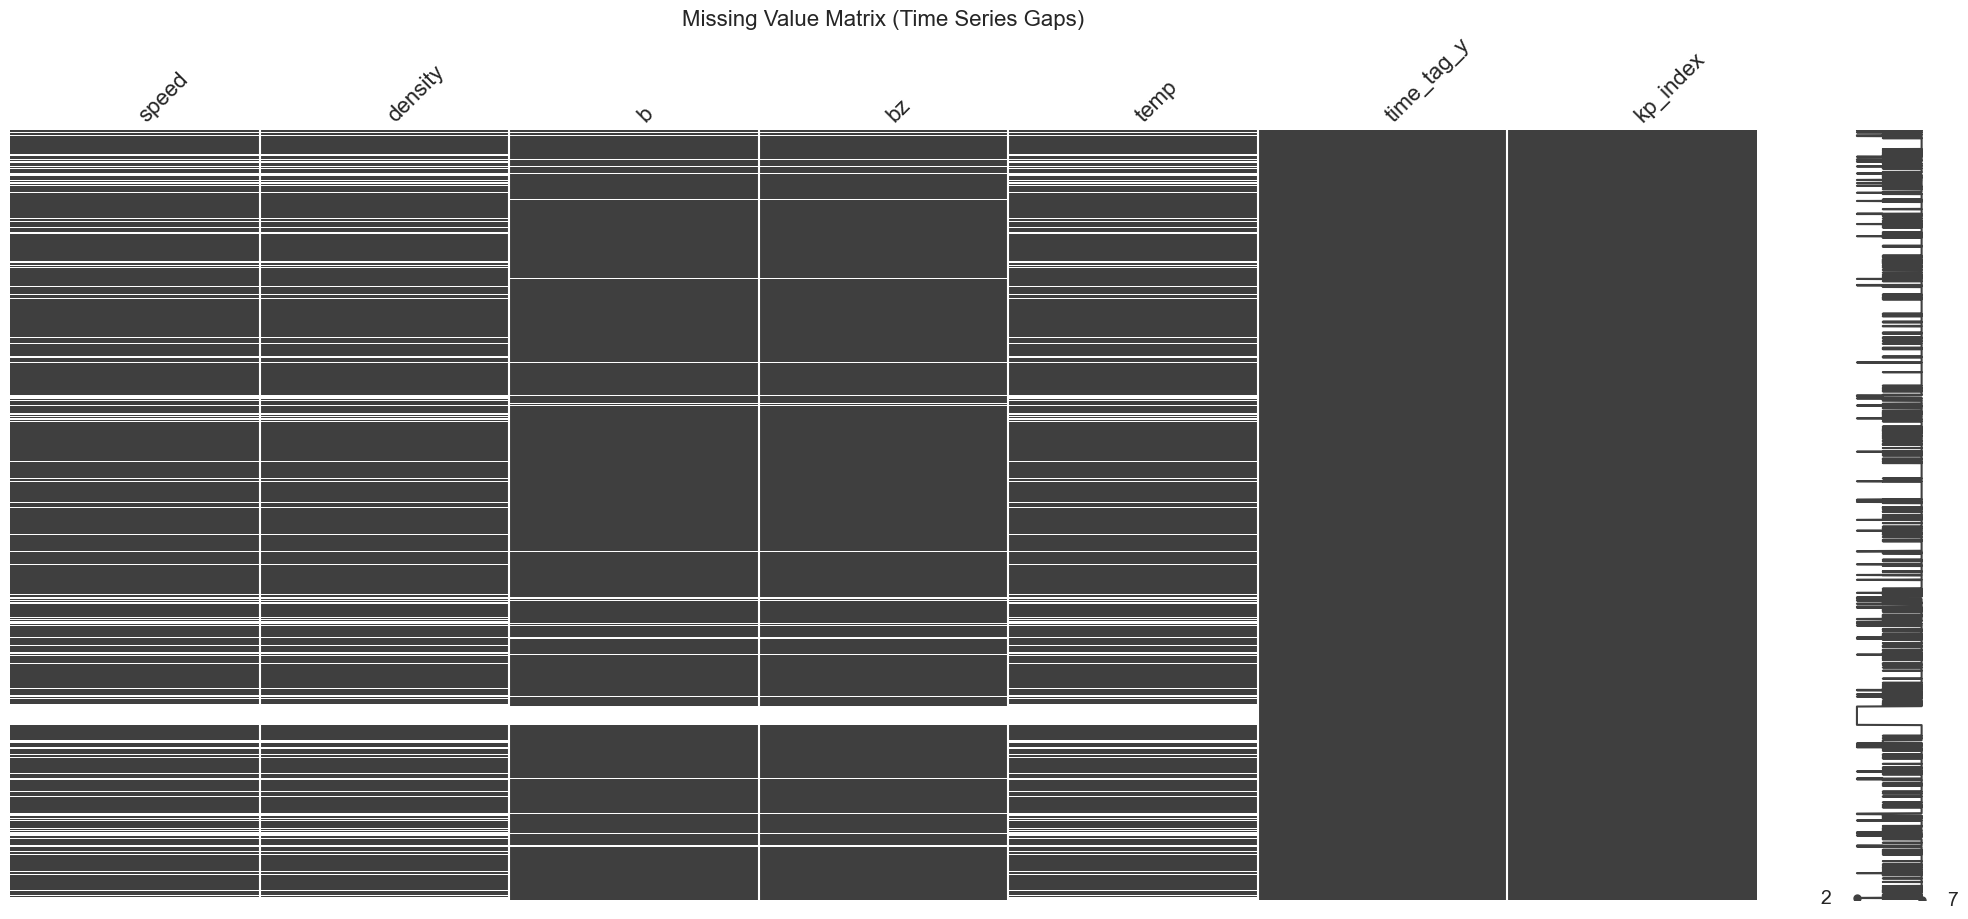

/var/folders/v7/_693nzgx4rl_8f0kw0jg8k980000gn/T/ipykernel_66982/560154306.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')


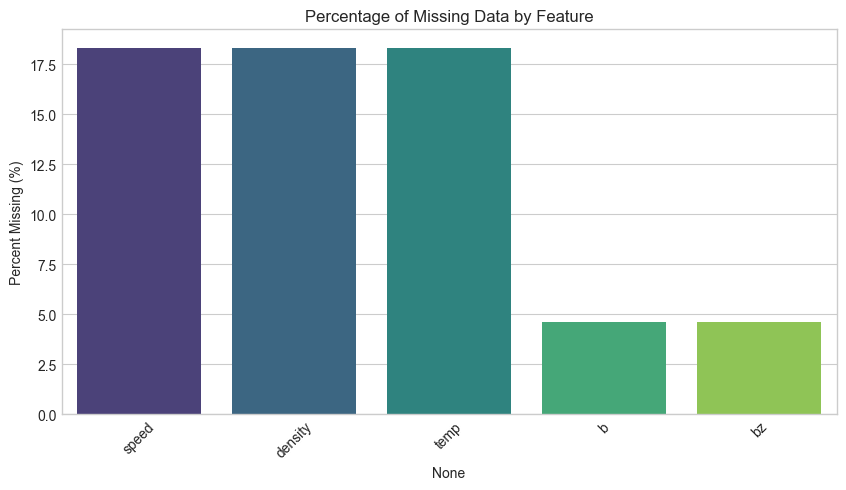

In [78]:
# Using missingno to visualize gaps in the time series
df = df.set_index('time_tag_x')
plt.figure(figsize=(15, 6))
msno.matrix(df, freq='M') # 'M' resamples to Month for readability if data is high-res
plt.title("Missing Value Matrix (Time Series Gaps)", fontsize=16)
plt.show()

# Percentage of missing values per column
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_percent.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')
    plt.title("Percentage of Missing Data by Feature")
    plt.ylabel("Percent Missing (%)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No missing values found (or already handled in fetch step).")

             time_tag       speed  density     b    bz      temp  kp_index
0 2015-01-01 00:00:00  530.900024     2.97  5.93  1.41  139683.0       2.0
1 2015-01-01 00:24:00  532.400024     2.97  6.07  1.12  132034.0       2.0
2 2015-01-01 00:48:00  531.500000     3.25  5.93  0.91  122762.0       2.0
3 2015-01-01 01:12:00  530.799988     3.51  5.53  0.74  115642.0       2.0
4 2015-01-01 01:36:00         NaN      NaN   NaN   NaN       NaN       2.0


/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Figure size 1500x600 with 0 Axes>

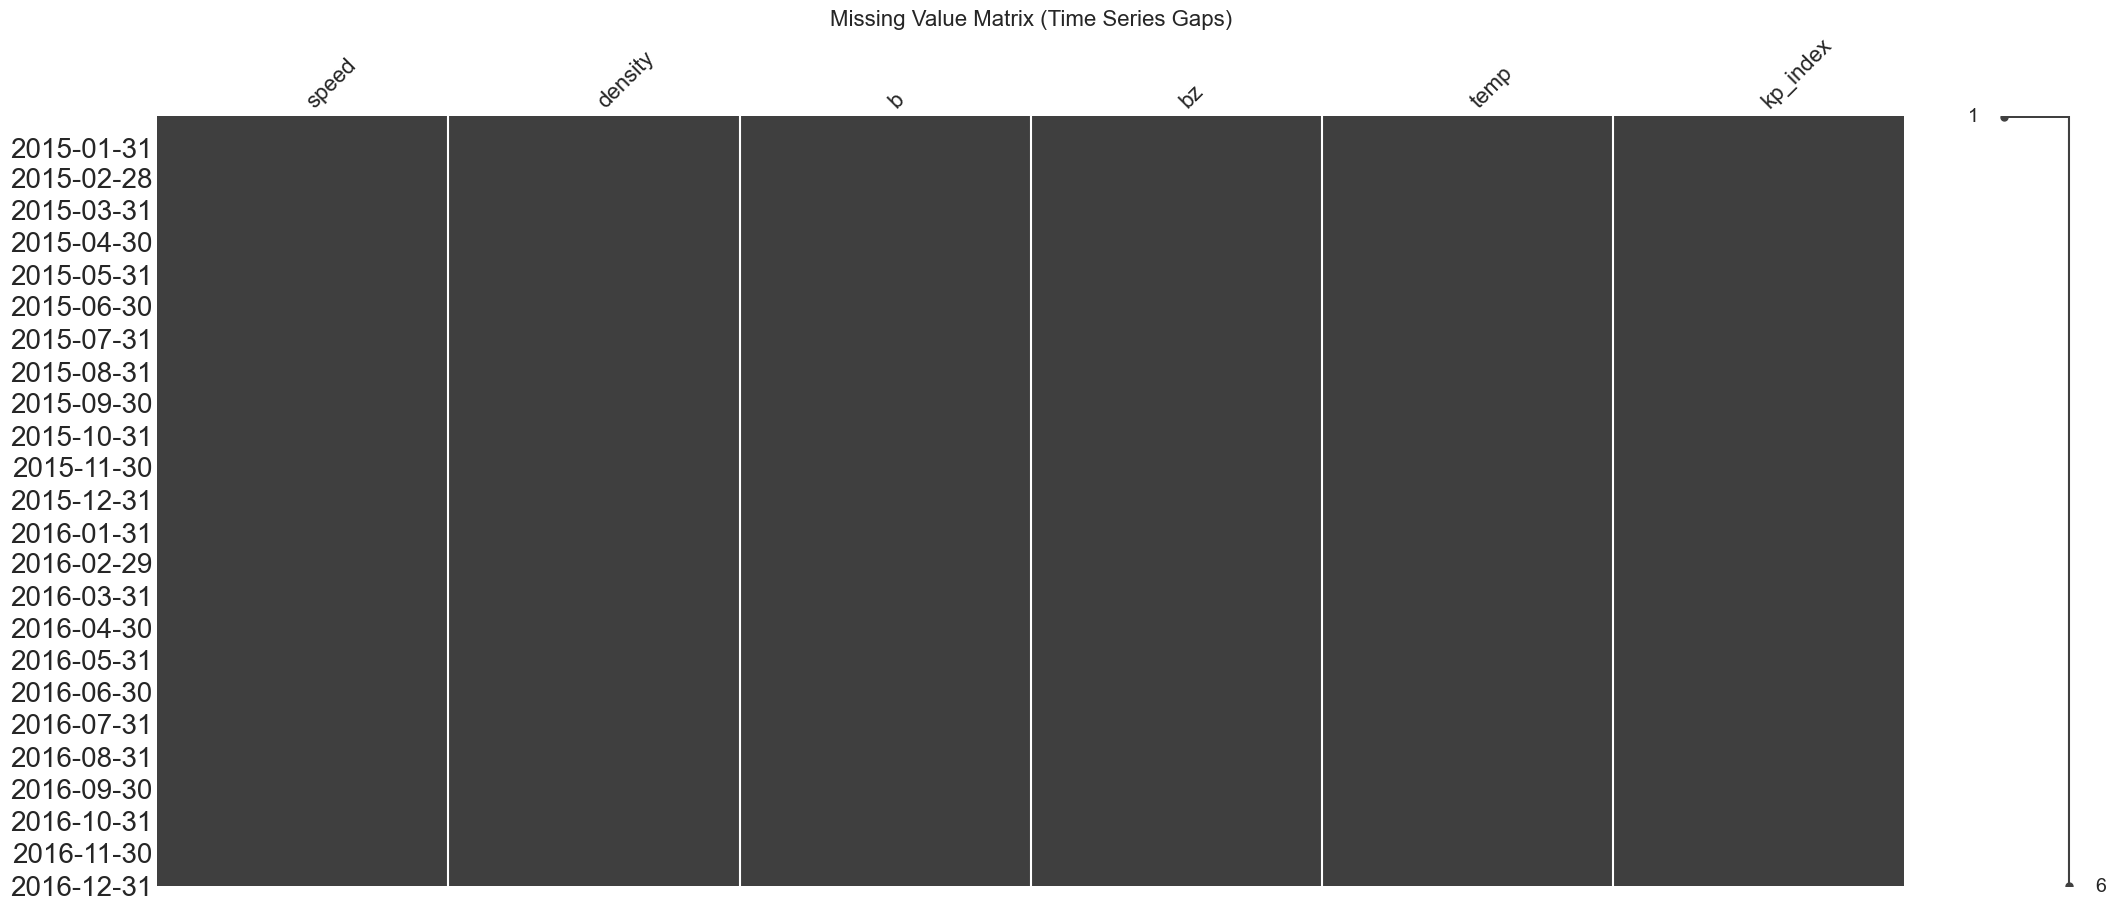

/var/folders/v7/_693nzgx4rl_8f0kw0jg8k980000gn/T/ipykernel_66982/1134704849.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')


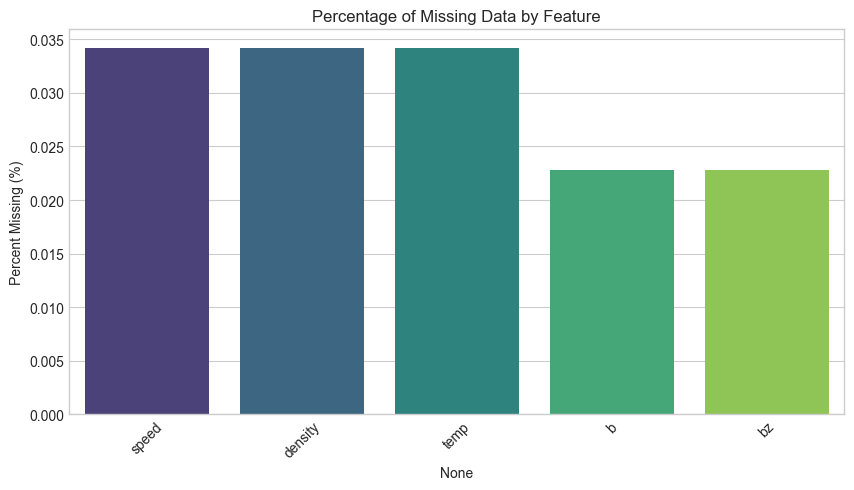

In [79]:
sw_df = sw_df.groupby('time_tag').mean().reset_index()
kp_df = kp_df.groupby('time_tag').mean().reset_index()
kp_df = kp_df.set_index('time_tag').resample('1min').ffill()
df = pd.merge(sw_df, kp_df, on='time_tag', how='inner')
print(df.head())

df = df.set_index('time_tag')
plt.figure(figsize=(15, 6))
msno.matrix(df, freq='M') # 'M' resamples to Month for readability if data is high-res
plt.title("Missing Value Matrix (Time Series Gaps)", fontsize=16)
plt.show()

# Percentage of missing values per column
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_percent.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')
    plt.title("Percentage of Missing Data by Feature")
    plt.ylabel("Percent Missing (%)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No missing values found (or already handled in fetch step).")

# 3. Distributions & Outliers
Checking the distribution of key physical parameters (e.g., `bz`, `speed`, `density`).

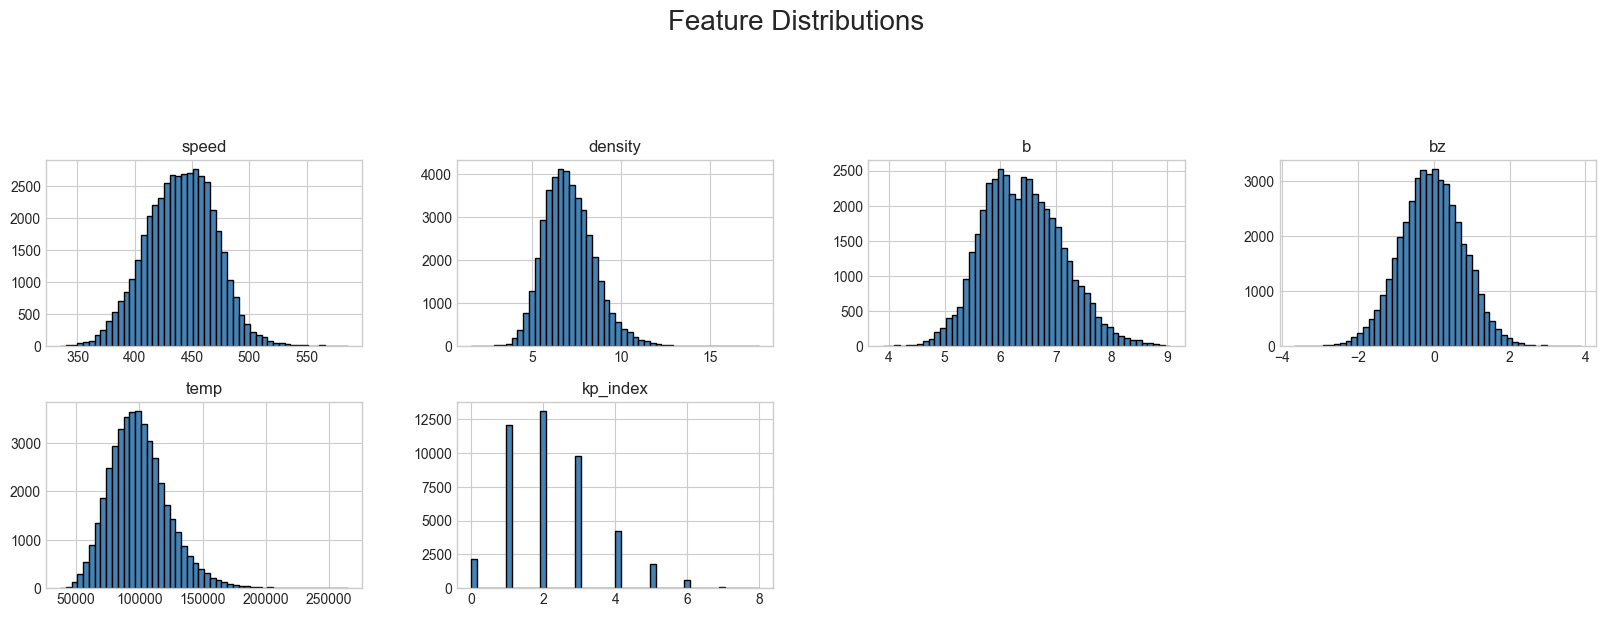

In [80]:
# Identify numerical columns (excluding Kp usually, which is ordinal/discrete-like)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms
df[num_cols].hist(bins=50, figsize=(20, 15), layout=(5, 4), color='steelblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=20)
plt.show()

# 4. Feature Engineering
We apply the pipeline steps `clean_solarwind`, `add_time_features`, and `add_moving_averages` to see how features change.

In [81]:
# 1. Clean
df = df.reset_index() # Made time_tag index for previous plot, reset so not dropped in next step
df_clean = clean_solarwind(df)
# 2. Add Time Features (Cyclical)
df_features = add_time_features(df_clean)

# 3. Add Moving Averages 
ma_cols = ['speed', 'density', 'bz', 'b']
df_final = add_moving_averages(df_features, columns=ma_cols)

print(f"Shape after feature engineering: {df_final.shape}")
df_final.head()

Shape after feature engineering: (43853, 18)


/Users/shaanpatel/Desktop/AuroraNet/src/data/preprocess.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


,time_tag,speed,density,b,bz,temp,kp_index,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,year,speed_ma3,density_ma3,bz_ma3,b_ma3
0,2015-01-01 00:00:00,530.900024,2.97,5.93,1.41,139683.0,2.0,0.000000,1.000000,0.017213,0.999852,0.5,0.866025,15,530.900024,2.970000,1.410000,5.930000
1,2015-01-01 00:24:00,532.400024,2.97,6.07,1.12,132034.0,2.0,0.000000,1.000000,0.017213,0.999852,0.5,0.866025,15,531.650024,2.970000,1.265000,6.000000
2,2015-01-01 00:48:00,531.500000,3.25,5.93,0.91,122762.0,2.0,0.000000,1.000000,0.017213,0.999852,0.5,0.866025,15,531.600016,3.063333,1.146667,5.976667
3,2015-01-01 01:12:00,530.799988,3.51,5.53,0.74,115642.0,2.0,0.258819,0.965926,0.017213,0.999852,0.5,0.866025,15,531.566671,3.243333,0.923333,5.843333
4,2015-01-01 01:36:00,530.799988,3.51,5.53,0.74,115642.0,2.0,0.258819,0.965926,0.017213,0.999852,0.5,0.866025,15,531.033325,3.423333,0.796667,5.663333


# 5. Correlation Analysis
We look at how features correlate with the target (`kp_index`).

/var/folders/v7/_693nzgx4rl_8f0kw0jg8k980000gn/T/ipykernel_66982/4135224835.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')


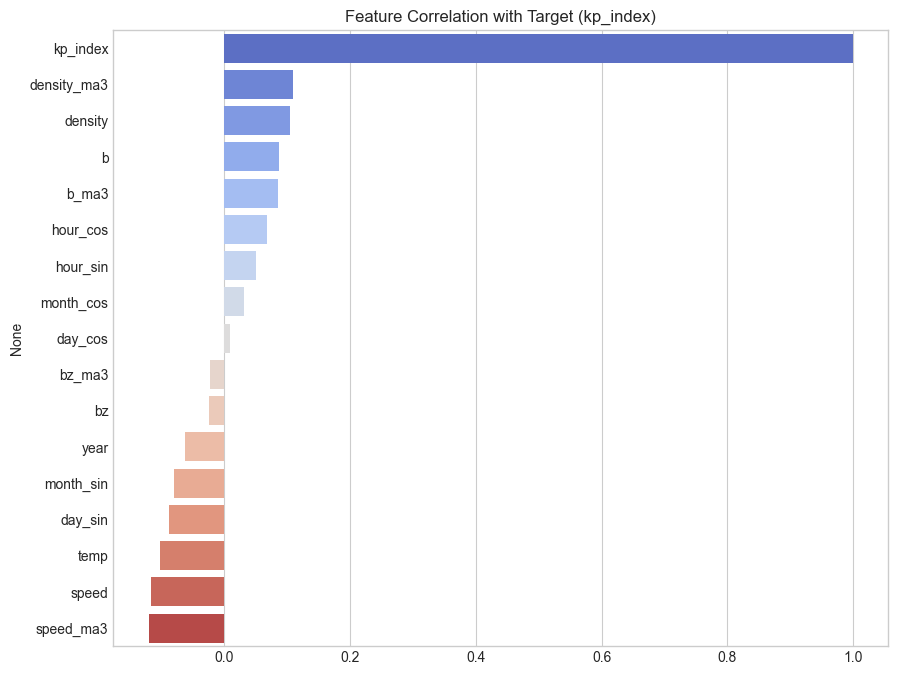

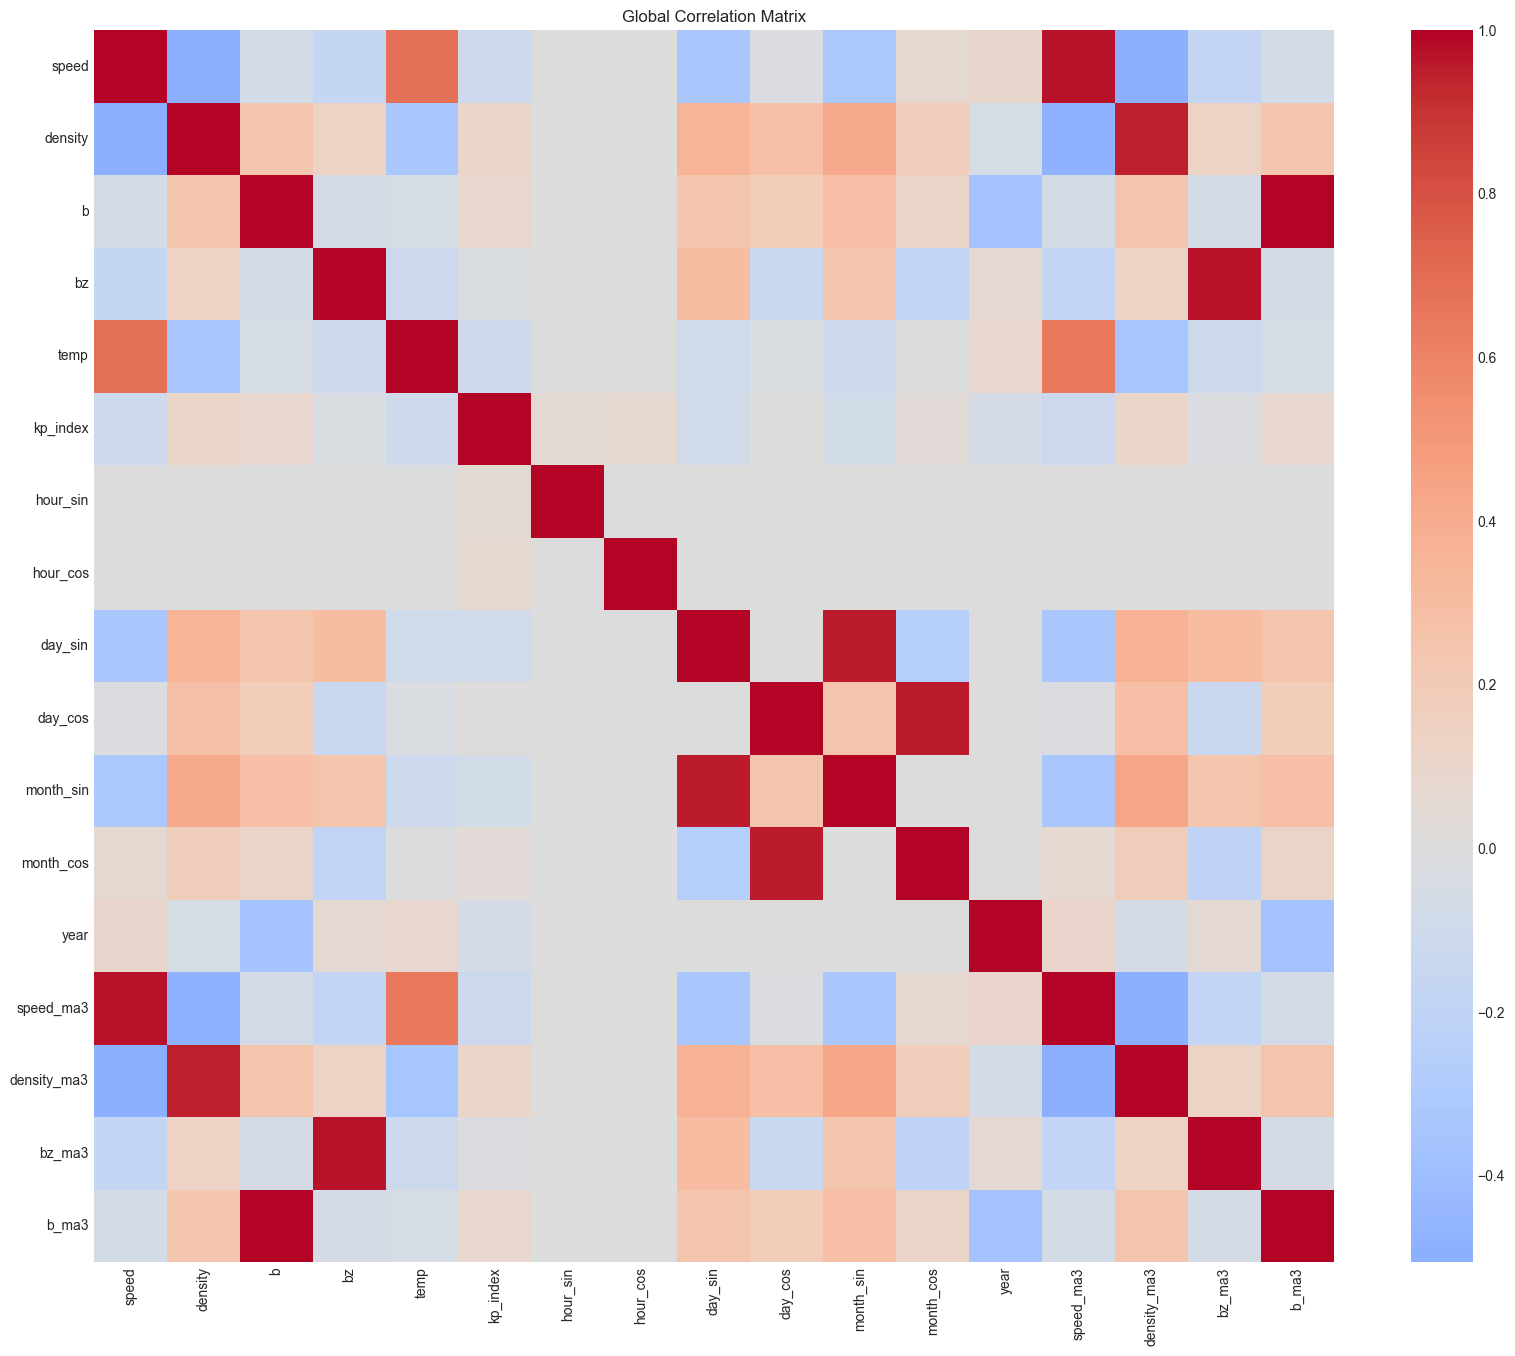


Variance Inflation Factor (Top Correlated Features):


,Feature,VIF
3,b_ma3,4900.336958
2,b,4831.008769
0,density_ma3,290.751943
1,density,257.392533
10,year,118.459385
12,day_sin,44.627429
6,month_cos,44.468356
7,day_cos,44.442952
11,month_sin,44.010759
13,temp,22.340822


In [82]:
def analyze_correlations(df, target_col='kp_index'):
    # Select numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # 1. Correlation with Target
    corr_with_target = numeric_df.corrwith(numeric_df[target_col]).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
    plt.title(f"Feature Correlation with Target ({target_col})")
    plt.show()

    # 2. Full Heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', center=0)
    plt.title("Global Correlation Matrix")
    plt.show()

    # 3. VIF (Variance Inflation Factor) check for Multicollinearity
    # (Handling infinite values or NaNs first if present)
    clean_num = numeric_df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    
    # Selecting a subset if too many columns (e.g., top 15 correlated)
    top_cols = corr_with_target.head(15).index.tolist()
    X = clean_num[top_cols].drop(columns=[target_col], errors='ignore')
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    print("\nVariance Inflation Factor (Top Correlated Features):")
    display(vif_data.sort_values(by='VIF', ascending=False))

analyze_correlations(df_final, target_col='kp_index')

# 6. Time Series Visualization
For Aurora data we need to visualize the time series, specifically identifying storm events (high Kp).

                time_tag       speed   density         b        bz  \
4380 2015-03-15 00:00:00  444.093750  8.205000  6.170500  1.532000   
4381 2015-03-15 00:24:00  451.566681  7.640000  6.031579  1.592105   
4382 2015-03-15 00:48:00  440.005249  7.693158  6.286190  0.902857   
4383 2015-03-15 01:12:00  437.083344  7.775556  5.937500  1.084000   
4384 2015-03-15 01:36:00  436.177795  7.324444  6.062381  1.004762   

               temp  kp_index  hour_sin  hour_cos   day_sin  day_cos  \
4380  103699.625000       2.0  0.000000  1.000000  0.956235   0.2926   
4381  108292.664062       2.0  0.000000  1.000000  0.956235   0.2926   
4382  105304.687500       2.0  0.000000  1.000000  0.956235   0.2926   
4383  109054.945312       2.0  0.258819  0.965926  0.956235   0.2926   
4384  104633.609375       2.0  0.258819  0.965926  0.956235   0.2926   

      month_sin     month_cos  year   speed_ma3  density_ma3    bz_ma3  \
4380        1.0  6.123234e-17    15  444.337229     7.786461  1.382818  

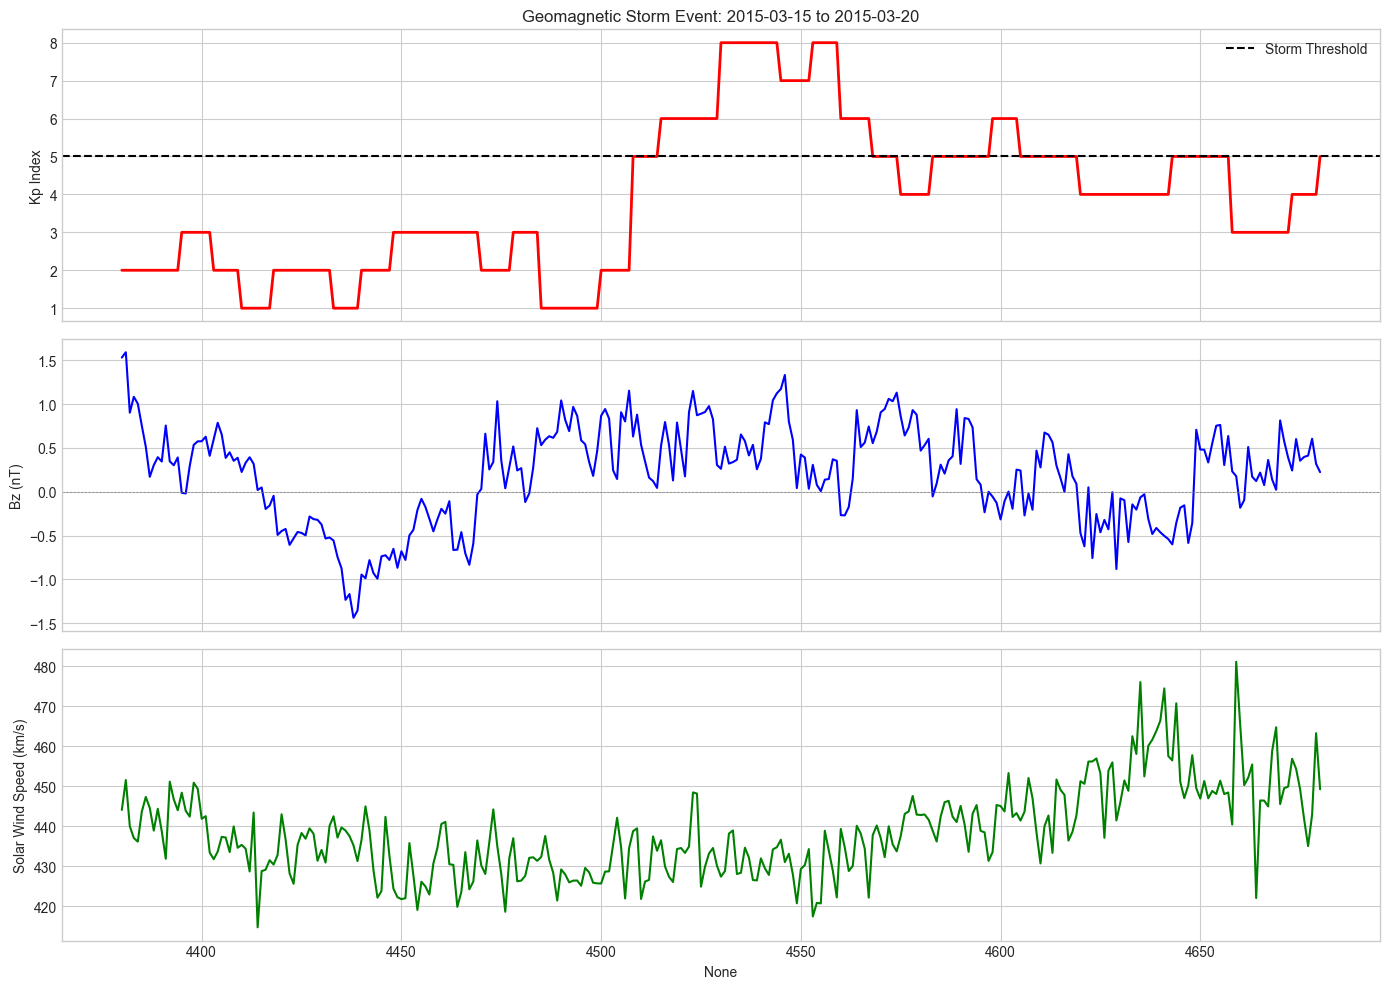

In [83]:
def plot_storm_event(df, start_date, end_date):
    """Plots Solar Wind parameters and Kp index for a specific date range."""
    subset = df.loc[
    (df['time_tag'] >= start_date) &
    (df['time_tag'] <= end_date)
]
    print(subset.head())
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)
    
    # Plot Kp
    if 'kp_index' in subset.columns:
        sns.lineplot(data=subset, x=subset.index, y='kp_index', ax=axes[0], color='red', linewidth=2)
        axes[0].set_ylabel("Kp Index")
        axes[0].set_title(f"Geomagnetic Storm Event: {start_date} to {end_date}")
        axes[0].axhline(y=5, color='black', linestyle='--', label='Storm Threshold')
        axes[0].legend()

    # Plot Bz (Interplanetary Magnetic Field) - Critical for storms
    # Adjust column name 'bz' based on your actual data schema
    bz_col = [c for c in subset.columns if 'bz' in c.lower()]
    if bz_col:
        sns.lineplot(data=subset, x=subset.index, y=bz_col[0], ax=axes[1], color='blue')
        axes[1].set_ylabel("Bz (nT)")
        axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

    # Plot Speed/Density
    # Adjust column names 'speed', 'density' based on schema
    speed_col = [c for c in subset.columns if 'speed' in c.lower()]
    if speed_col:
        sns.lineplot(data=subset, x=subset.index, y=speed_col[0], ax=axes[2], color='green')
        axes[2].set_ylabel("Solar Wind Speed (km/s)")

    plt.tight_layout()
    plt.show()

# Example: St. Patrick's Day Storm 2015
plot_storm_event(df_final, '2015-03-15', '2015-03-20')